# Zurich Land Cover Classification

This script presents a visualization of training a U-Net classifier on 7 out of 8 available land cover classes of the Zurich dataset, and detecting the unseen class using a Density Forest.

## 1. Import Libraries

In [22]:
%matplotlib inline
# python libraries
from matplotlib.patches import Rectangle
from multiprocessing import cpu_count
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import sys
import pandas as pd

# custom libraries
from helpers.helpers import *
from helpers.data_augment import *
from keras_helpers.unet import *
from keras_helpers.helpers import *
from keras_helpers.callbacks import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from sklearn import decomposition
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code') # Path to density Tree package
sys.path.append(base_dir + '/SIE-Master/Code/density_tree') # Path to density Tree package
from density_tree.density_forest import *
from density_tree.plots import *
from density_tree.helpers import get_balanced_subset_indices
from helpers.plots import *

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5284184684191170964
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 130482176
locality {
  bus_id: 1
}
incarnation: 18109190703948921821
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:03:00.0, compute capability: 6.1"
]


In [23]:
class_to_remove = 1

## 2. Load Images

In [8]:
path = os.getcwd()

imgs, gt = load_data(path)

# gt to labels
# Next, we need to convert the ground truth (colors) to labels 
legend = OrderedDict((('Background', [255, 255, 255]),
                      ('Roads', [0, 0, 0]),
                      ('Buildings', [100, 100, 100]),
                      ('Trees', [0, 125, 0]),
                      ('Grass', [0, 255, 0]),
                      ('Bare Soil', [150, 80, 0]),
                      ('Water', [0, 0, 150]),
                      ('Railways', [255, 255, 0]),
                      ('Swimming Pools', [150, 150, 255])))

# get class names by increasing value (as done above)
names, colors = [], []
for name, color in legend.items():
    names.append(name)
    colors.append(color)
    
gt = gt_color_to_label(gt, colors)

images: 20 
ground truth images: 20 


In [9]:
colors = np.asarray(colors)/255

### 2.2. Get patches

In [10]:
# Get patches
patch_size = 64
stride_train = 64  # has to be <= patch_size
stride_test = 32  # has to be <= patch_size

# ids for training, validation and test sets (0-19)
ids_train = np.arange(0, 12)
ids_val = np.arange(12, 16)
ids_test = np.arange(16, 20)

# get training, test and validation sets
x_train = get_padded_patches(imgs[ids_train], patch_size=patch_size, stride=stride_train)
x_val = get_padded_patches(imgs[ids_val], patch_size=patch_size, stride=stride_train)
x_test = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=stride_test)
x_test_nostride = get_padded_patches(imgs[ids_test], patch_size=patch_size, stride=patch_size)

y_train = get_gt_patches(gt[ids_train], patch_size=patch_size, stride=stride_train)
y_val = get_gt_patches(gt[ids_val], patch_size=patch_size, stride=stride_train)
y_test = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=stride_test)
y_test_nostride = get_gt_patches(gt[ids_test], patch_size=patch_size, stride=patch_size)

print(x_test.shape)
print(x_test_nostride.shape)

(3902, 64, 64, 4)
(964, 64, 64, 4)


## 3. Keras CNN

Data Split: 
- Training: 12 images
- Validation: 4 images
- Test: 4 images

Tested Architectures: 

| Model | Patch Size | Data Augmentations | Number of Parameters | Testing Precision (avg) | Testing Recall (avg) | Testing f1 score (avg) | Validation / Test accuracy |
| ------- | ------- | ------- | ------- | ------- | ------- |
| U-Net | 64 | Rot 90°, Flipping  | 7,828,200 | 0.87 | 0.858 | 0.86 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.69 | 0.61 | 0.64 | t |
| U-Net | 128 | Rot 90°, Flipping  | 7,828,200 | 0.90 | 0.89 | 0.89 | v |

In [11]:
# create copies of original data
y_train_label = y_train.copy()
y_val_label = y_val.copy()
y_test_label = y_test.copy()

In [12]:
# get class weights
labels_unique = np.unique(y_train.flatten())
print(labels_unique)
class_weights = class_weight.compute_class_weight('balanced', labels_unique, y_train.flatten())
class_weights[0] = 0  # give less weight to background label class
class_weights[5] = 7  # give less weight to bare soil class
class_weights[8] = 7  # give less weight to swimming pool class

print("Class weights:")
for i, w in enumerate(class_weights):
    print("%15s: %3.3f" % (names[i], w))

[0 1 2 3 4 5 6 7 8]
Class weights:
     Background: 0.000
          Roads: 0.757
      Buildings: 0.480
          Trees: 1.508
          Grass: 2.105
      Bare Soil: 7.000
          Water: 2.006
       Railways: 6.211
 Swimming Pools: 7.000


In [13]:
n_classes = 9

# convert to numpy arrays
x_train = np.asarray(x_train)
x_val = np.asarray(x_val)
x_test = np.asarray(x_test)

# make y data categorical
y_train = to_categorical(y_train_label, n_classes)
y_val = to_categorical(y_val_label, n_classes)

# remove class
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])

names_keep = np.asarray(names)[classes_to_keep]
names_keep = names_keep.tolist()
print("classes to keep: " + str(names_keep))

y_train = y_train[..., classes_to_keep]
y_val = y_val[..., classes_to_keep]
n_classes = len(classes_to_keep)
class_weights = class_weights[classes_to_keep]

# print shapes of variables
for var in x_train, y_train, x_val, y_val:
    print(np.shape(var))

classes to keep: ['Buildings', 'Trees', 'Grass', 'Bare Soil', 'Water', 'Railways', 'Swimming Pools']
(3897, 64, 64, 4)
(3897, 64, 64, 7)
(1117, 64, 64, 4)
(1117, 64, 64, 7)


### 3.1. Train CNN

In [14]:
# callbacks (evaluated every epoch)
# show loss and accuracy figures after each epoch
callback_plot = PlotLosses()

# stop early if after several epochs the accuracy doesn't improve
callback_earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=24, verbose=1, mode='auto')

# decrease learning rate when accuracy stops improving
callback_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=12, verbose=1, mode='auto',
                                epsilon=1e-4, cooldown=0, min_lr=1e-8)

# checkpoint to save weights at every epoch (in case of interruption)
file_path = "weights-improvement.hdf5"
callback_checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

callback_tensorboard = TensorBoard(log_dir='./tensorboard', histogram_freq=0, write_graph=True, write_images=True)

# model setup
batch_size = 20
epochs = 300


def model_train(model, data_augmentation):
    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(batch_generator(x_train, y_train,
                                        batch_size=batch_size, data_augmentation=data_augmentation),
                        steps_per_epoch=int(np.ceil(x_train.shape[0] / float(batch_size))),
                        epochs=epochs,
                        verbose=1,
                        class_weight=class_weights,  # weights for loss function
                        validation_data=(x_val, y_val),
                        callbacks=[callback_earlystop,
                                   callback_lr,
                                   #callback_checkpoint,
                                   callback_plot,
                                   callback_tensorboard],
                        workers=cpu_count(),
                        use_multiprocessing=True)

<Figure size 432x288 with 0 Axes>

In [15]:
# train or load model
# train the model
#model_unet = get_unet(n_classes, x_train.shape[1:])
#model_train(model_unet, data_augmentation=True)
#model_unet.save('models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '_2.h5')  # save model, weights

In [16]:
# load model
name_model = path + '/models_out/model_unet_64_flip_rot90_wo_cl_' + str(names[class_to_remove]).lower() + '.h5'    
model_unet = load_model(name_model, custom_objects={'fn': ignore_background_class_accuracy(0)})

### 3.2. Prediction on Test Set

In [17]:
# get prediction
y_pred = model_unet.predict(x_test, batch_size=20, verbose=1)

# prediction patches without overlapping patches
y_pred = np.concatenate(remove_overlap(imgs, y_pred, ids_test, 64, 32))

# get label
y_pred_label = get_y_pred_labels(y_pred, class_to_remove=class_to_remove)

# get accuracy as softmax pseudo-probability
y_pred_acc = np.max(y_pred, axis=-1)

# Get accuracy as margin between highest and second highest class
y_pred_acc_margin = get_acc_net_max_margin(y_pred)

3902/3902 [==============================] - 4s 1ms/step


In [18]:
# prediction image
y_pred_acc_imgs = [convert_patches_to_image(imgs, y_pred_acc[..., np.newaxis],
                                       img_idx=idx_im, img_start=ids_test[0], patch_size=64,
                                       stride=64) for idx_im in ids_test]

In [19]:
y_pred_im = [convert_patches_to_image(imgs, gt_label_to_color(y_pred_label, colors), img_idx=i, img_start=16, patch_size=64,
                             stride=64) for i in ids_test]


### 3.3. Accuracy Metrics (Test Set)

In [20]:
# Accuracy metrics
y_pred_flattened= np.asarray(y_pred_label.flatten()).astype('int')
y_test_flattened= np.asarray(y_test_nostride.flatten()).astype('int')

# mask background and removed classes for evaluation metrics
filter_items = (y_test_flattened != 0) & (y_test_flattened != class_to_remove)

# Class accuracy, average accuracy
print(metrics.classification_report(
    y_test_flattened[filter_items],
    y_pred_flattened[filter_items],
    target_names=names_keep,
    digits=3))


# Overall accuracy
OA = metrics.accuracy_score(y_test_flattened[filter_items], y_pred_flattened[filter_items])
print("Overall accuracy: %.3f %%" % (OA*100))

                precision    recall  f1-score   support

     Buildings      0.802     0.978     0.881    470587
         Trees      0.885     0.869     0.877    545015
         Grass      0.960     0.831     0.891    612397
     Bare Soil      0.880     0.734     0.801     66093
         Water      0.873     0.816     0.844     18705
      Railways      0.052     0.085     0.064     18526
Swimming Pools      0.000     0.000     0.000     10386

   avg / total      0.875     0.866     0.866   1741709

Overall accuracy: 86.594 %


/opt/conda/envs/python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## 4. Certainty using Density Forest
### 4.1. Retrieve Activations, PCA, t-SNE

In [24]:
# image, layer indexes
layer_idx = -2
img_idx = 2
batch_size = 20

# get activations for training Density Forest
act_train = get_activations(imgs, model_unet, layer_idx, x_train, ids_train, batch_size=160, patch_size=64, stride=64)

100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


In [25]:
# get activations for seen classes

# retain only activation weights for which there is a ground truth
filter_seen = (y_train_label != 0) & (y_train_label != class_to_remove)
act_train_seen = np.concatenate(act_train)[filter_seen] 

# all but those belonging to background
act_train = np.concatenate(act_train)[y_train_label != 0]

In [26]:
# get activations for testing Density Forest
act_test = get_activations(imgs, model_unet, layer_idx, x_test, ids_test, batch_size=160, patch_size=64, stride=32)

# remove test activations overlap
act_test = remove_overlap(imgs, np.concatenate(act_test), ids_test, patch_size=64, stride=32) 

# all labels, including background
act_test = np.concatenate(act_test, axis=0)[y_test_nostride < np.infty] # convert to 1D

100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


In [27]:
# get balanced data subset to show in figure
dataset_subset_indices = get_balanced_subset_indices(y_test_nostride.flatten(), np.arange(1,9), pts_per_class=200)

In [28]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=500)
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])
tsne_y = y_test_nostride.flatten()[np.concatenate(dataset_subset_indices)]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.004s...
[t-SNE] Computed neighbors for 1600 samples in 0.151s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.984817
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.584427
[t-SNE] Error after 500 iterations: 0.489493


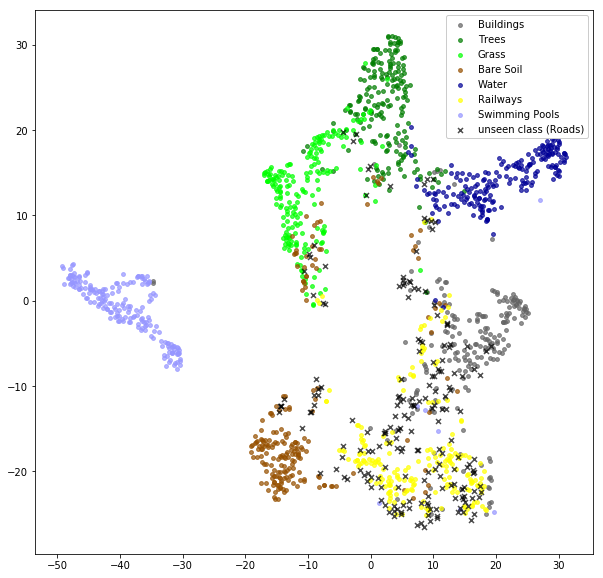

In [31]:
# plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)

In [32]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=5)
pca.fit(act_train)  # fit on training set without background pixels
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

# transform activations
act_train_seen = pca.transform(act_train_seen)
act_train = pca.transform(act_train)
act_test = pca.transform(act_test)

Variance explained by first 5 components: 0.96


In [33]:
# t-SNE visualization after PCA
tsne_all = tsne.fit_transform(act_test[np.concatenate(dataset_subset_indices)])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1600 samples in 0.001s...
[t-SNE] Computed neighbors for 1600 samples in 0.056s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1600
[t-SNE] Computed conditional probabilities for sample 1600 / 1600
[t-SNE] Mean sigma: 0.897332
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.172878
[t-SNE] Error after 500 iterations: 0.467554


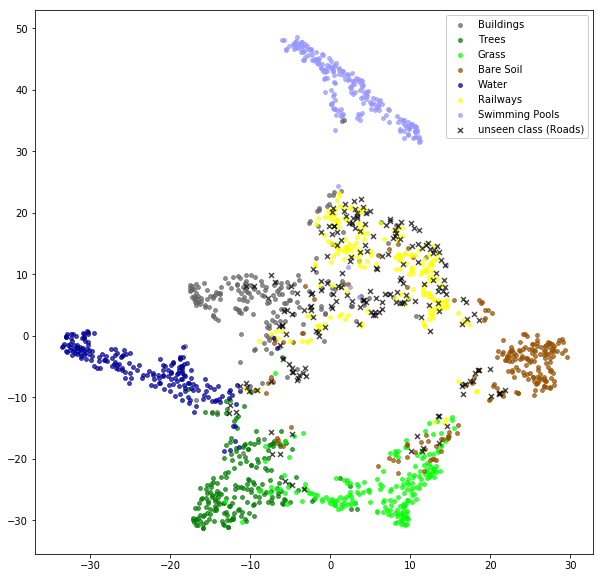

In [37]:
# plot
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, names, colors, class_to_remove=class_to_remove)

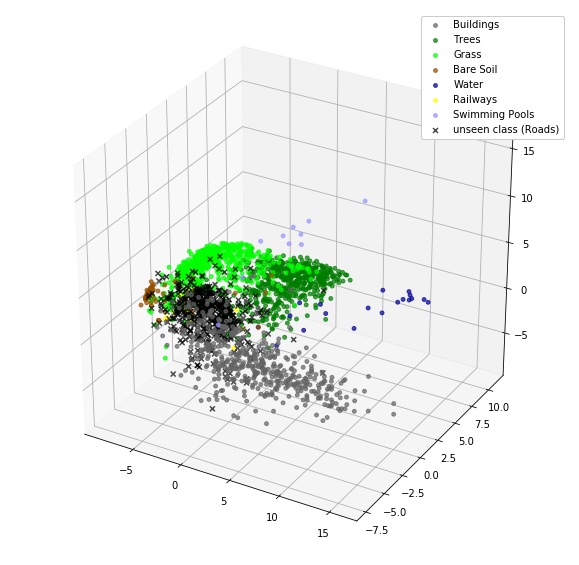

Variance explained by first 3 components: 0.89


In [38]:
# plot PCA point
plot_pts_3d(act_test[:,:3], y_test_nostride.flatten(), classes_to_keep, names, colors,
            class_to_remove=class_to_remove, subsample_pct=.001)

print("Variance explained by first 3 components: %.2f" % np.sum(pca.explained_variance_ratio_[:3]))

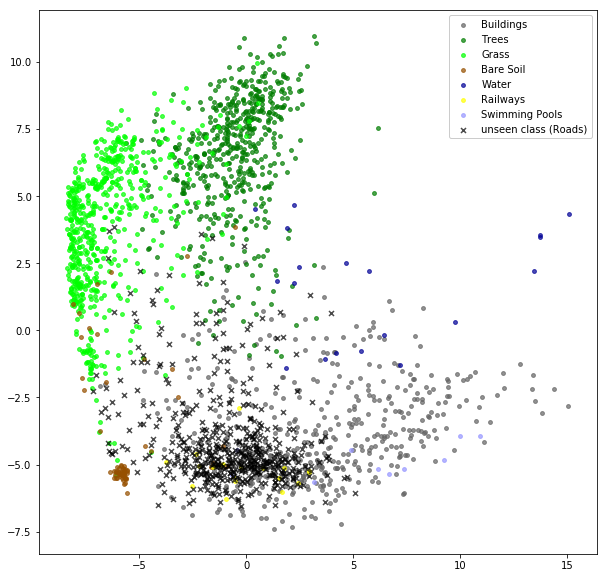

In [39]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
plot_pts_2d(act_test[:,:2], y_test_nostride.flatten(), ax, classes_to_keep, names, colors,
            class_to_remove=class_to_remove, subsample_pct=.001)

# Gaussian Mixture Model
GMM trained on activations after PCA (~15 components)

In [40]:
y_train_label_seen = y_train_label[(y_train_label!=class_to_remove) & (y_train_label!=0)]
ind = np.concatenate(get_balanced_subset_indices(y_train_label_seen, classes_to_keep, 1000))

In [48]:
gmm = GaussianMixture(n_components=len(classes_to_keep), max_iter=1000, verbose = 10)

In [49]:
gmm.fit(act_train_seen[ind])

Initialization 0
  Iteration 0	 time lapse 0.09119s	 ll change inf
  Iteration 10	 time lapse 0.11795s	 ll change 0.02442
  Iteration 20	 time lapse 0.10771s	 ll change 0.00282
  Iteration 30	 time lapse 0.10113s	 ll change 0.00330
  Iteration 40	 time lapse 0.09317s	 ll change 0.00210
Initialization converged: True	 time lapse 0.52080s	 ll -8.97750


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
        means_init=None, n_components=7, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=10,
        verbose_interval=10, warm_start=False, weights_init=None)

In [50]:
probas = gmm.predict_proba(act_test)
probas = get_acc_net_entropy(probas)

In [53]:
# post-treatment
# reshape probas to (n_patches, patch_size, patch_size)
patches_start = get_offset(imgs, 64, 64, 16, 16) # idx of first patch in image
patches_end = get_offset(imgs, 64, 64, 16, 20) # idx of first patch in image
n_patches = patches_end - patches_start
probas_seen_im = np.reshape(probas, (n_patches,patch_size,patch_size))

# transformations
probas_seen_im -= np.nanmin(probas_seen_im)
probas_seen_im /= np.nanmax(probas_seen_im)

# save probabilities corresponding to an image in an array
probas_imgs = [] # (n_imgs, n_patches, patch_size, patch_size)
for idx_im in ids_test:
    patches_start = get_offset(imgs, 64, 64, 16, idx_im) # idx of first patch in image
    patches_end = get_offset(imgs, 64, 64, 16, idx_im+1) # idx of last patch in image
    probas_im = np.asarray(probas_seen_im[patches_start:patches_end])
    probas_imgs.append(probas_im)
    
probas_patches = np.concatenate(probas_imgs) # all patches concatenated (like y_test)

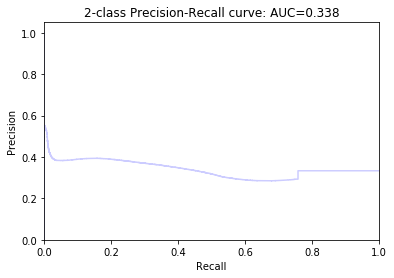

In [54]:
# GMM
y_scores = -probas_patches.flatten()
y_true = (y_test_nostride != y_pred_label).flatten()

filt = y_test_nostride.flatten()!=0
y_true = y_true[filt]
y_scores = y_scores[filt]
precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores)
plot_precision_recall(precision, recall, s_name="../Figures/DF/AUC/AUC_pred_wo_cl_" + str(class_to_remove) + "_DF.pdf")#y_scores = probas_patches.flatten()

/opt/conda/envs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


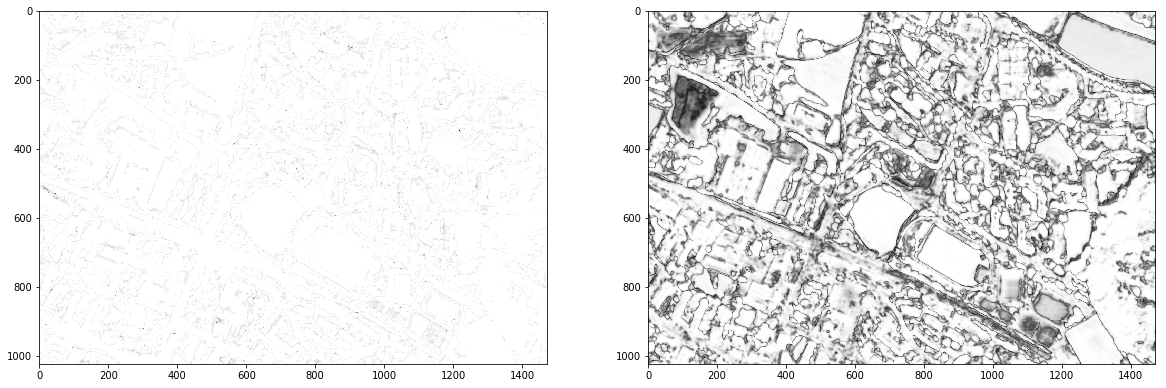

In [55]:
# show image of DF uncertainty vs. max margin uncertainty
img_idx=3
acc_im_ = convert_patches_to_image(imgs, probas_patches[...,np.newaxis], img_idx+16, 64, 64,16)
acc_im = np.log(acc_im_)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(acc_im[...,0], cmap='gray')
axes[1].imshow(y_pred_acc_imgs[img_idx][...,0], cmap='gray')

In [ ]:
# doesn't seem to work, let's try parametric t-sne

## Parametric t-SNE
GMM/DF applied to parametric t-SNE

In [56]:
from parametric_tSNE.core import *
from parametric_tSNE.utils import *

In [57]:
# perform high-dimensional t-sne
high_dims = act_test.shape[-1]
num_outputs = 2
perplexity = 30
ptSNE = Parametric_tSNE(high_dims, num_outputs, perplexity, batch_size=1000)
ptSNE.fit(draw_subsamples(act_test,.01), epochs=100, verbose=1)

2018-06-06 17:34:48.657323: Pretraining 4 layers
Epoch 1/100
39485/39485 [==============================] - 5s - loss: 4.6465      
Epoch 2/100
39485/39485 [==============================] - 0s - loss: 0.7502     
Epoch 3/100
39485/39485 [==============================] - 0s - loss: 0.1559     
Epoch 4/100
39485/39485 [==============================] - 0s - loss: 0.0679     
Epoch 5/100
39485/39485 [==============================] - 0s - loss: 0.0512     
Epoch 6/100
39485/39485 [==============================] - 0s - loss: 0.0473     
Epoch 7/100
39485/39485 [==============================] - 0s - loss: 0.0443     
Epoch 8/100
39485/39485 [==============================] - 0s - loss: 0.0416     
Epoch 9/100
39485/39485 [==============================] - 0s - loss: 0.0411     
Epoch 10/100
39485/39485 [==============================] - 0s - loss: 0.0388     
Epoch 11/100
39485/39485 [==============================] - 0s - loss: 0.0395     
Epoch 12/100
39485/39485 [====================

39485/39485 [==============================] - 0s - loss: 0.0144     
Epoch 98/100
39485/39485 [==============================] - 0s - loss: 0.0148     
Epoch 99/100
39485/39485 [==============================] - 0s - loss: 0.0141     
Epoch 100/100
39485/39485 [==============================] - 0s - loss: 0.0147     
Epoch 1/100
39485/39485 [==============================] - 0s - loss: 1.4036     
Epoch 2/100
39485/39485 [==============================] - 0s - loss: 0.5466     
Epoch 3/100
39485/39485 [==============================] - 0s - loss: 0.4824     
Epoch 4/100
39485/39485 [==============================] - 0s - loss: 0.4738     
Epoch 5/100
39485/39485 [==============================] - 0s - loss: 0.4051     
Epoch 6/100
39485/39485 [==============================] - 0s - loss: 0.3808     
Epoch 7/100
39485/39485 [==============================] - 0s - loss: 0.3404     
Epoch 8/100
39485/39485 [==============================] - 0s - loss: 0.3120     
Epoch 9/100
39485/39485 

39485/39485 [==============================] - 0s - loss: 1.4542     
Epoch 94/100
39485/39485 [==============================] - 0s - loss: 1.4540     
Epoch 95/100
39485/39485 [==============================] - 0s - loss: 1.4545     
Epoch 96/100
39485/39485 [==============================] - 0s - loss: 1.4537     
Epoch 97/100
39485/39485 [==============================] - 0s - loss: 1.4542     
Epoch 98/100
39485/39485 [==============================] - 0s - loss: 1.4537     
Epoch 99/100
39485/39485 [==============================] - 0s - loss: 1.4540     
Epoch 100/100
39485/39485 [==============================] - 0s - loss: 1.4538     
2018-06-06 17:35:52.656816: Finished pretraining
2018-06-06 17:35:52.699183: Beginning training on 100 epochs
Epoch 1/100
39/39 [==============================] - 6s - loss: 984.4603     
Epoch 2/100
39/39 [==============================] - 4s - loss: 802.2194     
Epoch 3/100
39/39 [==============================] - 4s - loss: 776.6464     
Epoc

In [59]:
tsne_train = ptSNE.transform(act_train)

In [60]:
tsne_test = ptSNE.transform(act_test)

In [68]:
y_train_label_seen = y_train_label[y_train_label!=0].flatten()

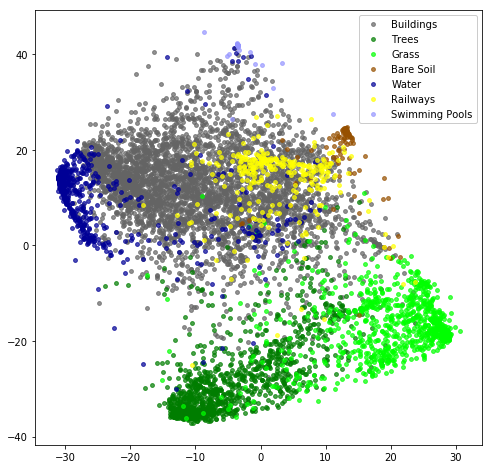

In [73]:
# plot
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_pts_2d(tsne_train, y_train_label_seen, ax, classes_to_keep, names,
            colors, subsample_pct=.001)

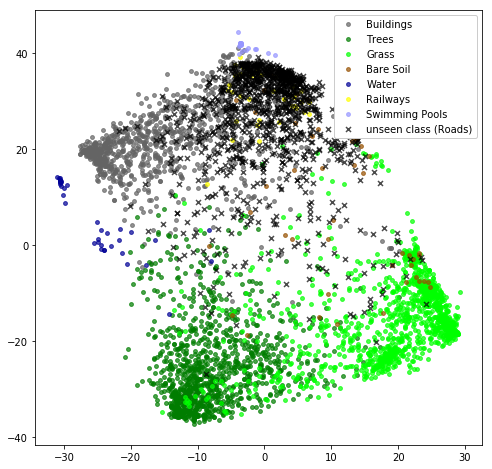

In [79]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
plot_pts_2d(tsne_test, y_test_nostride.flatten(), ax, classes_to_keep,names,
           colors, class_to_remove=class_to_remove, subsample_pct=.002)